## Microsoft Building Footprints Example

Bing Maps is releasing open building footprints around the world. The building footprints are detected using Bing Maps imagery between 2014 and 2021 including Maxar and Airbus imagery. The data is freely available for download and use under ODbL.

In [1]:
import geopandas
import planetary_computer
import pystac_client
import dask.dataframe
import dask_geopandas
import dask.distributed
import shapely.geometry
import contextily

### Data access

The datasets hosted by the Planetary Computer are available from [Azure Blob Storage](https://docs.microsoft.com/en-us/azure/storage/blobs/). We'll use [pystac-client](https://pystac-client.readthedocs.io/) to search the Planetary Computer's [STAC API](https://planetarycomputer.microsoft.com/api/stac/v1/docs) for the subset of the data that we care about, and then we'll load the data directly from Azure Blob Storage. We'll specify a `modifier` so that we can access the data stored in the Planetary Computer's private Blob Storage Containers. See [Reading from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) and [Using tokens for data access](https://planetarycomputer.microsoft.com/docs/concepts/sas/) for more.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

### Querying the STAC API

The files are available as a set of GeoParquet datasets, released in batches by date. There's one parquet datsaet per region-date pair.

In [3]:
items = catalog.search(
    collections=["ms-buildings"], query={"msbuildings:region": {"eq": "Vatican City"}}
)
item = next(items.items())
item

<Item id=Vatican City_2022-07-06>

This STAC item has a `data` asset linking to the GeoParquet dataset with the building footprints.

In [4]:
asset = item.assets["data"]

df = geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
df.head()

,geometry,quadkey
0,"POLYGON ((12.45281 41.90667, 12.45270 41.90667...",120232221
1,"POLYGON ((12.45628 41.90528, 12.45625 41.90467...",120232221
2,"POLYGON ((12.45183 41.90168, 12.45199 41.90172...",120232221
3,"POLYGON ((12.45091 41.90227, 12.45095 41.90249...",120232221
4,"POLYGON ((12.44829 41.90253, 12.44824 41.90256...",120232221


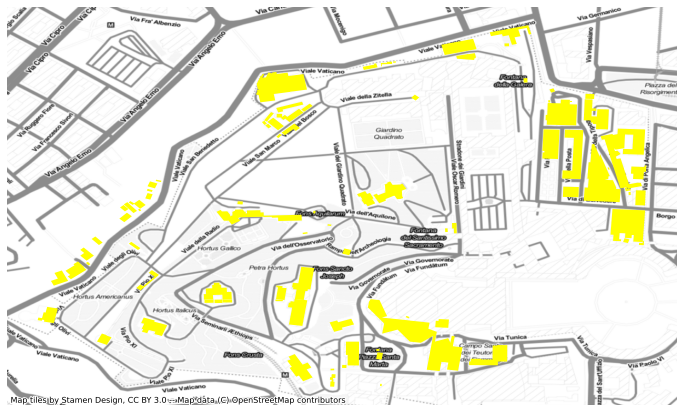

In [5]:
ax = df.plot(figsize=(12, 12), color="yellow")
contextily.add_basemap(
    ax, source=contextily.providers.Stamen.TonerLite, crs=df.crs.to_string()
)
ax.set_axis_off()

### Working with large files

The full dataset is partitioned by region. To avoid very large files for regions with many buildings, regions available as [Parquet Datasets](https://arrow.apache.org/docs/python/parquet.html#partitioned-datasets-multiple-files) consiting of multiple Parquet files. You can use libraries like [Dask](https://dask.org/) or [Apache Spark](https://spark.apache.org/) to load in the partioned data. This example uses Dask to process the data in parallel.

In [6]:
client = dask.distributed.Client()
print(client.dashboard_link)

2022-08-15 16:26:39,684 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-uw48mpth', purging
2022-08-15 16:26:39,684 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-f1bk36gy', purging
2022-08-15 16:26:39,684 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-hpas2z1a', purging
2022-08-15 16:26:39,685 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-omqqkv_3', purging


/user/taugspurger@microsoft.com/proxy/8787/status


We'll search for items from the `Germany` region.

In [7]:
items = catalog.search(
    collections=["ms-buildings"], query={"msbuildings:region": {"eq": "Germany"}}
)
item = next(items.items())
asset = item.assets["data"]

The asset's `href` points to the root of a Parquet datset in Azure Blob Storage. We'll use dask-geopandas to load the dataset. This gives a `dask_geopandas.GeoDataFrame` with 13 partitions.

In [8]:
germany = dask_geopandas.read_parquet(
    asset.href, storage_options=asset.extra_fields["table:storage_options"]
)
germany

,geometry,RegionName,quadkey
npartitions=188,,,
,geometry,category[known],category[known]
,...,...,...
...,...,...,...
,...,...,...
,...,...,...


We'll visualize the footprints for a small region outside the town of Ueckermünde in Northeast Germany.

In [9]:
mask = shapely.geometry.box(14.11, 53.73, 14.13, 53.75)

The data have been spatially partitioned by quadkeys using the [Bing Maps Tile System](https://docs.microsoft.com/en-us/bingmaps/articles/bing-maps-tile-system), which enables efficient access to spatial subsets of each dataset. The entire `germany` dataset hundreds of spatial partitions, but we want data from just two partitions.

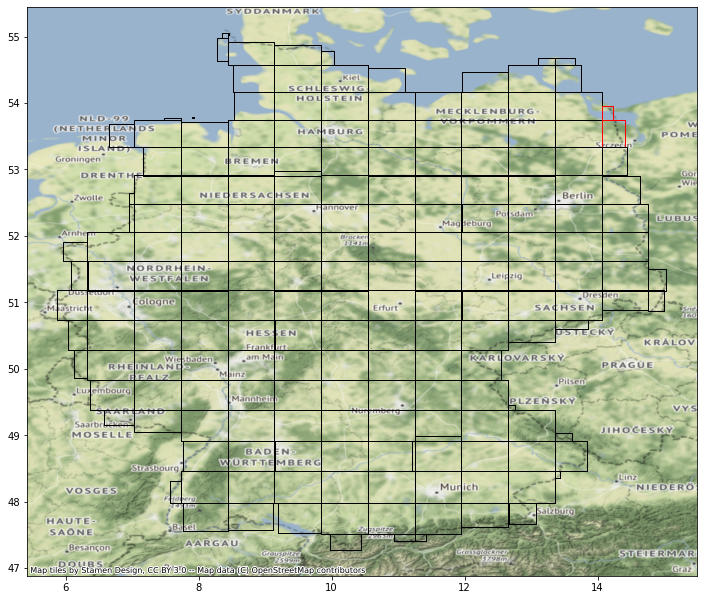

In [10]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 12))

color = ["r" if x else "k" for x in germany.spatial_partitions.intersects(mask)]
germany.spatial_partitions.plot(facecolor="none", edgecolor=color, ax=ax)
contextily.add_basemap(ax, crs=germany.crs.to_string())

We can [clip](https://geopandas.org/en/stable/gallery/plot_clip.html?highlight=clip#Clip-Vector-Data-with-GeoPandas) the dataset to just the region of interest, which will efficiently load data from only the spatial partitoins intersecting that area.

In [11]:
subset = germany.clip(mask).compute()

In [12]:
subset.explore()

You can even work with the full global dataset, across all regions, if you'd like.

In [13]:
df_global = dask.dataframe.read_parquet(
    "az://footprints/global/2022-06-14/ml-buildings.parquet",
    storage_options=asset.extra_fields["table:storage_options"],
)
df_global

,geometry,RegionName
npartitions=3531,,
,object,category[known]
,...,...
...,...,...
,...,...
,...,...


### Next steps

This example briefly demonstrated searching the STAC catalog and loading the data with geopandas. To learn more, visit the following resources:

* Learn more about [geopandas](https://geopandas.readthedocs.io).
* Learn more about [Dask](https://dask.org/)
* Learn more about [geoparquet](https://github.com/opengeospatial/geoparquet)
* Learn more about the [Global MLBuildings Footprints](https://github.com/microsoft/GlobalMLBuildingFootprints/) project.